<a href="https://colab.research.google.com/github/nsx07/word2vec-cbow/blob/main/CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CBOW from Scratch

In [ ]:
import numpy as np
import re

class CBOW:

    def __init__(self, embedding_dim, window_size, epochs, learning_rate):
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.window_size = window_size
        self.epochs = epochs

        self.training_data = None
        self.vocab_size = None
        self.vocab = None
        self.word_to_index = None
        self.index_to_word = None
        self.encoded_training_data = None

        self.embeddings = None
        self.output_weights = None

    def separate_sentences(self, text):
      sentences = re.split(r'[.!?;(...)]+', text)
      if sentences[-1] == '' or sentences[-1] == None:
          del sentences[-1]
      return sentences

    def create_vocabulary(self):
        all_words = ' '.join(self.training_data).lower()
        all_words = re.sub(r'[^\w\s]', '', all_words).split()
        self.vocab = sorted(set(all_words))
        self.vocab_size = len(self.vocab)
        self.word_to_index = {word: idx for idx, word in enumerate(self.vocab)}
        self.index_to_word = {idx: word for word, idx in self.word_to_index.items()}

    def create_vec_to_word_map(self):
        self.vec_to_word = {str(self.one_hot(word)): word for word in self.vocab}

    def one_hot(self, word):
        one_hot_vector = np.zeros(self.vocab_size)
        one_hot_vector[self.word_to_index[word]] = 1
        return one_hot_vector

    def encode_training_data(self):
        self.encoded_training_data = []

        for sentence in self.training_data:
            tokens = re.sub(r'[^\w\s]', '', sentence).lower().split()

            for word_pos, word in enumerate(tokens):
                target_word = self.one_hot(word)
                context_words = []

                for context_pos in range(word_pos - self.window_size, word_pos + self.window_size + 1):
                    if 0 <= context_pos < len(tokens) and context_pos != word_pos:
                        context_words.append(tokens[context_pos])

                self.encoded_training_data.append((target_word, context_words))

    def initialize_weights(self):
        self.embeddings = np.random.rand(self.vocab_size, self.embedding_dim)
        self.output_weights = np.random.rand(self.embedding_dim, self.vocab_size)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def get_average_context_vector(self, context):
        avg_vector = np.zeros(self.embedding_dim)
        for word in context:
            avg_vector += self.embeddings[self.word_to_index[word]]
        return avg_vector / len(context)

    def compute_loss(self, y, y_hat):
        return -np.sum(y * np.log(y_hat))

    def update_weights(self, error, avg_context_vec, context):
        self.output_weights -= self.learning_rate * np.outer(avg_context_vec, error)
        EH = np.dot(self.output_weights, error)
        for word in context:
            self.embeddings[self.word_to_index[word]] -= self.learning_rate * EH

    def train(self, training_data):
        self.training_data = self.separate_sentences(training_data)

        self.create_vocabulary()
        self.create_vec_to_word_map()
        self.encode_training_data()
        self.initialize_weights()

        self.losses = []

        for epoch in range(self.epochs):
            total_loss = 0
            for target_word, context in self.encoded_training_data:
                avg_context_vec = self.get_average_context_vector(context)
                scores = np.dot(avg_context_vec, self.output_weights)
                y_pred = self.softmax(scores)

                error = y_pred - target_word
                total_loss += self.compute_loss(target_word, y_pred)

                self.update_weights(error, avg_context_vec, context)

            self.losses.append(total_loss)

    def find_target_word(self, y_pred, vocab, window_size):
      sorted_y_pred = y_pred.copy()
      sorted_y_pred.sort()
      sorted_y_pred = sorted_y_pred[::-1]
      score = sorted_y_pred[:1]
      index = np.where(y_pred == score)[0][0]

      return vocab[index]

    def print_embeddings(self):
        if self.embeddings is None or self.vocab is None:
            print("O modelo ainda não foi treinado.")
            return

        for word, idx in self.word_to_index.items():
            print(word)
            print(self.embeddings[idx], '\n')

### Parametros e execução

In [ ]:
SOURCE = "Pierre, after all, had not managed to choose a career for himself in Petersburg, and had been expelled from there for riotous conduct and sent to Moscow. The story told about him at Count Rostóv’s was true. Pierre had taken part in tying a policeman to a bear. He had now been for some days in Moscow and was staying as usual at his father’s house. Though he expected that the story of his escapade would be already known in Moscow and that the ladies about his father—who were never favorably disposed toward him—would have used it to turn the count against him, he nevertheless on the day of his arrival went to his father’s part of the house. Entering the drawing room, where the princesses spent most of their time, he greeted the ladies, two of whom were sitting at embroidery frames while a third read aloud. It was the eldest who was reading—the one who had met Anna Mikháylovna. The two younger ones were embroidering: both were rosy and pretty and they differed only in that one had a little mole on her lip which made her much prettier. Pierre was received as if he were a corpse or a leper. The eldest princess paused in her reading and silently stared at him with frightened eyes; the second assumed precisely the same expression; while the youngest, the one with the mole, who was of a cheerful and lively disposition, bent over her frame to hide a smile probably evoked by the amusing scene she foresaw. She drew her wool down through the canvas and, scarcely able to refrain from laughing, stooped as if trying to make out the pattern."

LEARNING_RATE = 0.03
EMBEDDING_DIM = 10
WINDOW_SIZE = 4
EPOCHS = 300

w2v = CBOW(embedding_dim=EMBEDDING_DIM, learning_rate=LEARNING_RATE,
           window_size=WINDOW_SIZE, epochs=EPOCHS)

w2v.train(SOURCE)

### Gráficos 3D

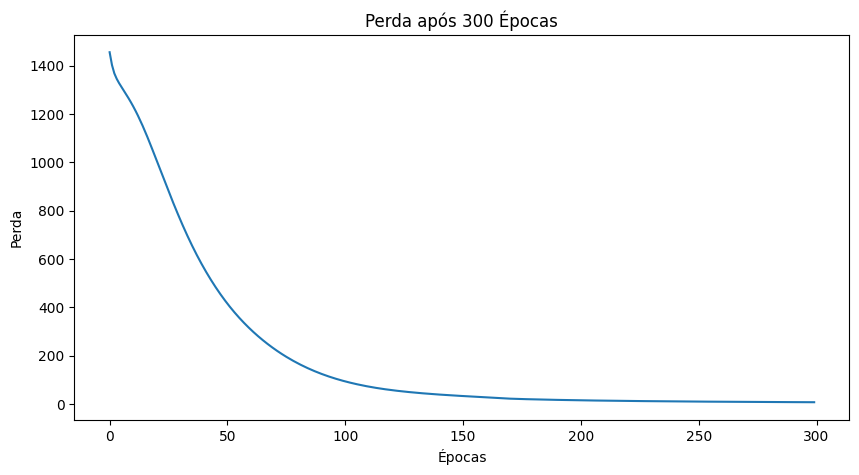

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f'Perda após {EPOCHS} Épocas')
ax.set_xlabel('Épocas')
ax.set_ylabel('Perda')
ax.plot(list(range(EPOCHS)), w2v.losses)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.io as pio

def plot_embeddings_plotly(embeddings, vocab):
    pca = PCA(n_components=3)
    reduced_embeddings = pca.fit_transform(embeddings)
    data = [go.Scatter3d(
        x=[embedding[0] for embedding in reduced_embeddings],
        y=[embedding[1] for embedding in reduced_embeddings],
        z=[embedding[2] for embedding in reduced_embeddings],
        text=vocab,
        mode='markers+text',
        marker=dict(size=5, opacity=0.8),
        textposition="bottom center"
    )]

    layout = go.Layout(
        title="Representações de Palavras em 3D",
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )

    fig = go.Figure(data=data, layout=layout)
    pio.show(fig)

plot_embeddings_plotly(w2v.embeddings, w2v.vocab)

### Embeddings

In [ ]:
w2v.print_embeddings()

a
[  3.7907903    8.79661321  -0.35203808  -7.90756247   1.20215842
   9.91012424   0.66960147 -13.64454668   1.73640115  -8.93237908] 

able
[-4.7089749   6.63948636 -1.09395457  2.42935117  3.201543    3.35051668
 -0.46378957  4.22239362  0.47318006 -2.78693827] 

about
[ 2.57680486  1.63532966  6.97023511  2.07509353 -0.79834911  1.63281358
 -3.04060118  7.06355515 -2.40808922  7.1718305 ] 

after
[ 2.76478679 -4.24442135  2.10262639  0.7056923   1.79921857  3.76140168
 -0.06313153  2.8582405   1.08957717 -1.16177102] 

against
[ 1.92790759  2.98833126  5.48729503  4.00691563  2.30226986  2.87976386
  0.6579508  -4.83967266  0.65418101  1.19783043] 

all
[ 1.0593616   0.43904396  3.69839337  3.32532456  2.01898927  3.49979918
 -0.46932024  1.90655292 -0.07945512 -3.58777431] 

aloud
[ 1.10296131  0.16478105 -0.72765374 -1.67940575 -0.05514659  0.47909788
 -1.31786156 -3.28458773  3.71107398  1.54416934] 

already
[-5.95234443 -0.5257904  -1.36014165 -0.65538778  0.39111486  0.531398